In [72]:
import pandas as pd
import zipfile
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [9]:
with zipfile.ZipFile("StockX-Data-Contest-2019-3.csv.zip","r") as zip_ref:
    zip_ref.extractall()

In [13]:
df=pd.read_csv("StockX-Data-Contest-2019-3.csv")
print(df.columns)
print(df.head())

Index(['Order Date', 'Brand', 'Sneaker Name', 'Sale Price', 'Retail Price',
       'Release Date', 'Shoe Size', 'Buyer Region'],
      dtype='object')
  Order Date   Brand                                   Sneaker Name  \
0     9/1/17   Yeezy           Adidas-Yeezy-Boost-350-Low-V2-Beluga   
1     9/1/17   Yeezy    Adidas-Yeezy-Boost-350-V2-Core-Black-Copper   
2     9/1/17   Yeezy     Adidas-Yeezy-Boost-350-V2-Core-Black-Green   
3     9/1/17   Yeezy       Adidas-Yeezy-Boost-350-V2-Core-Black-Red   
4     9/1/17   Yeezy  Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017   

  Sale Price Retail Price Release Date  Shoe Size  Buyer Region  
0     $1,097         $220      9/24/16       11.0    California  
1       $685         $220     11/23/16       11.0    California  
2       $690         $220     11/23/16       11.0    California  
3     $1,075         $220     11/23/16       11.5      Kentucky  
4       $828         $220      2/11/17       11.0  Rhode Island  


In [17]:
def extract_first_price(cell):
    try:
        prices=cell.replace("$","").split("$")
        prices=[float(p.replace(",","")) for p in prices if p.strip() !=""]
        return sum(prices)/len(prices) if prices else None
    except:
        return None

In [21]:
df['Sale Price']=df['Sale Price'].astype(str).apply(extract_first_price)

In [25]:
df=df.dropna(subset=['Sale Price'])

In [35]:
df['Order Date']=pd.to_datetime(df['Order Date'],errors='coerce')
df=df.dropna(subset=['Order Date'])
daily_prices=df.groupby('Order Date')['Sale Price'].mean().reset_index()
daily_prices=daily_prices.sort_values('Order Date')

In [37]:
scaler=MinMaxScaler()
scaled_prices=scaler.fit_transform(daily_prices[['Sale Price']])

In [41]:
def create_sequences(data,window_size):
    X,y=[],[]
    for i in range(window_size,len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])     
    return np.array(X),np.array(y)

In [65]:
window_size=20
X,y=create_sequences(scaled_prices,window_size)

In [67]:
split=int(len(X)*0.8)
X_train,X_test=X[:split],X[split:]
y_train,y_test=y[:split],y[split:]

In [87]:
model=Sequential([
    LSTM(50,return_sequences=False,input_shape=(X_train.shape[1],X_train.shape[2])),
    Dense(1)
])

C:\Users\Pearl Narang\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [89]:
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=30,batch_size=16,verbose=1)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0750
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0063
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0056
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053
Epoch 13/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076
Epoch 14/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060
Epoch 15/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051
Epoch 1

In [99]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_pred=model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [101]:
y_pred_inv=scaler.inverse_transform(y_pred)
y_test_inv=scaler.inverse_transform(y_test)

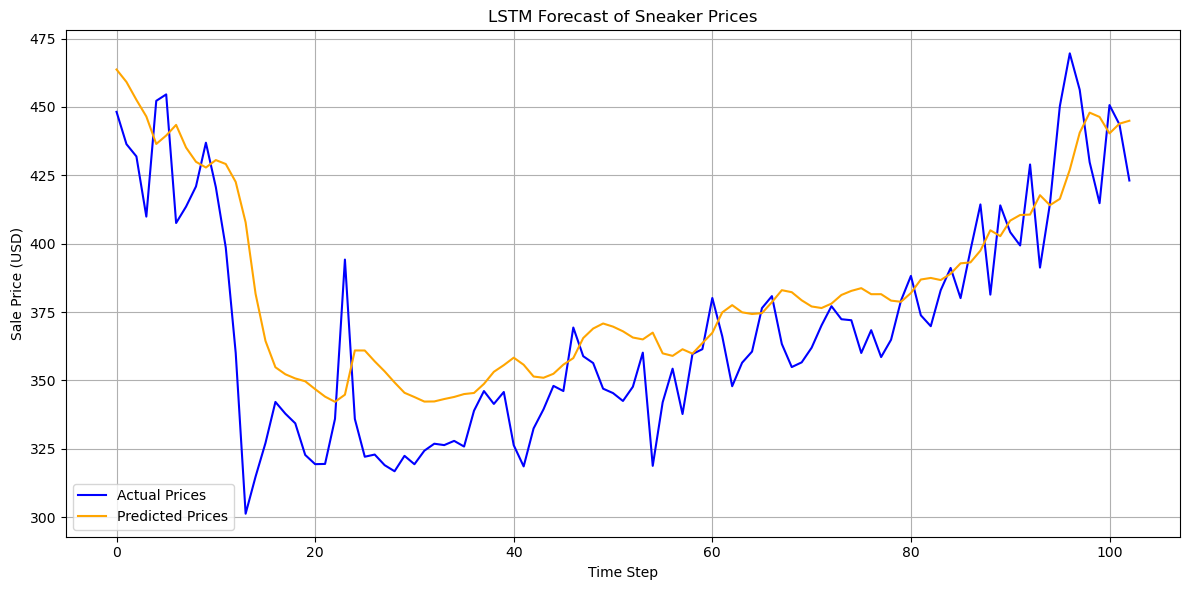

In [103]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(y_pred_inv, label='Predicted Prices', color='orange')
plt.title("LSTM Forecast of Sneaker Prices")
plt.xlabel("Time Step")
plt.ylabel("Sale Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [107]:
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 24.67


In [111]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_idx = y_true != 0  # avoid division by zero
    y_true, y_pred = y_true[non_zero_idx], y_pred[non_zero_idx]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 5.39%
